In [1]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.txtGraphPruning.graph_clustering import leiden_clustering, mini_graphs_from_clusters, louvain_clustering, iterative_leiden
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched, summarise_cluster
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse, summairse_clusters
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


### Step 1. ###
Load the model and download the website

In [2]:
# Load model
# model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
# state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model = GraphAttentionNetwork(in_dim = 119, pe_dim=11, edge_in_dim = 210, edge_emb_dim = 32, heads = 4)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/TrueTransformer-newtagsnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
#url = r"https://www.bbc.co.uk/news/articles/cpq5dl5y4nlo"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
# htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
# downloadHTML(url,1,htmlFile)

### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [3]:
# Start the process of gathering facts
LISTOFFACTS = []
LISTOFXPATHS = []

In [4]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted, title_label, title_txt, title_xpaths, title_probs = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/allmovie/0000", remove_dupes=REMOVE_DUPES)
#sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted, title_label, title_txt, title_xpaths, title_probs = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

In [5]:
print(len(txts_extracted))
for t, p in zip(txts_extracted, probs_extracted):
    print(t, p)

12882
['Similar Works', '» View DVD Releases'] 0.99293
['» View DVD Releases', 'Similar Works'] 0.98049015
['Other Related Works', '» View DVD Releases'] 0.9911773
['» View DVD Releases', 'Other Related Works'] 0.98128533
['Send to Friend', 'The Sweet Hereafter'] 0.9316978
['The Sweet Hereafter', 'Send to Friend'] 0.39312363
['Feature', 'Color'] 0.8450405
['Color', 'Feature'] 0.78899634
['1997', '110 min.'] 0.8078985
['110 min.', '1997'] 0.774681
['AMG Work ID', 'V   155010'] 0.80591524
['V   155010', 'AMG Work ID'] 0.60876185
['for sexuality and some language', 'MPAA Reasons'] 0.6354256
['MPAA Reasons', 'for sexuality and some language'] 0.1657438
['» Glossary', '» Coming Soon'] 0.63192964
['» Coming Soon', '» Glossary'] 0.12951595
['Brief Nudity', 'Flags'] 0.52445394
['Flags', 'Brief Nudity'] 0.07192811
['Review', 'Overview'] 0.497464
['Overview', 'Review'] 0.298932
['Douglas Fairbanks, Jr. (1909)', 'Donald Byrd (1932)'] 0.4565452
['Donald Byrd (1932)', 'Douglas Fairbanks, Jr. (1909)

In [6]:
print(len(title_txt))
for i in range(len(title_txt)):
    print(title_txt[i], title_probs[i])

114
Terms of Service 0.95352495
High Production Values 0.82679063
Donald Byrd (1932) 0.7597113
John Cassavetes (1929) 0.5989719
The Sweet Hereafter 0.5812753
» In the Spotlight 0.4089485
Privacy Policy 0.32439598
» New Releases 0.29720575
» Glossary 0.13245699
Overview 0.04787029
Product Submissions 0.04030317
High Artistic Quality 0.034052942
Plot Synopsis 0.02318225
Review 0.0148790525
Employment 0.011113101
Advertising 0.009759662
V   155010 0.0054162084
Is related to: 0.003681892
Cast 0.0031126447
R 0.0029824488
for sexuality and some language 0.0025523943
Countries 0.0025089167
Year 0.0020176298
Category 0.00194952
Canada 0.0014235529
British Columbia, Canada 0.0012709317
In a Minor Key 0.0012557361
by Jason Ankeny 0.001252931
Douglas Fairbanks, Jr. (1909) 0.0011859083
Panavision 0.0011456923
Drama 0.0010750935
Feature 0.00088871684
1997 0.00084284344
» AllMovie Blog 0.00059989135
Run Time 0.0005448966
Color Type 0.0005339032
» Essays 0.00053145294
Color 0.0004729498
110 min. 0.00

In [7]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, ",:\\-.%'\\s", lower=False), normalise_text(b, ",:\\-.%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [8]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [9]:
# Remove all html instructional labels
def get_sents(text):
        sents = re.split(r'(?<=[.!?])\s+', text.strip())
        return [s.strip() for s in sents if s.strip()]
    
txtsShortened = [[get_sents(a)[0], get_sents(b)[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=16)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        print(len(idx[0]),"-",key)
        isButtonNode[idx] = True

All the nodes filtered out:


1 - Category
1 - Contact
1 - Privacy Policy
1 - About Us
1 - View DVD Releases
1 - Send to Friend


In [10]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
node_unique_label_index, node_to_edge_pos, node_unique_txts, node_unique_xpaths = node_unique_label_index[~isButtonNode], node_to_edge_pos[~isButtonNode], node_unique_txts[~isButtonNode], node_unique_xpaths[~isButtonNode]

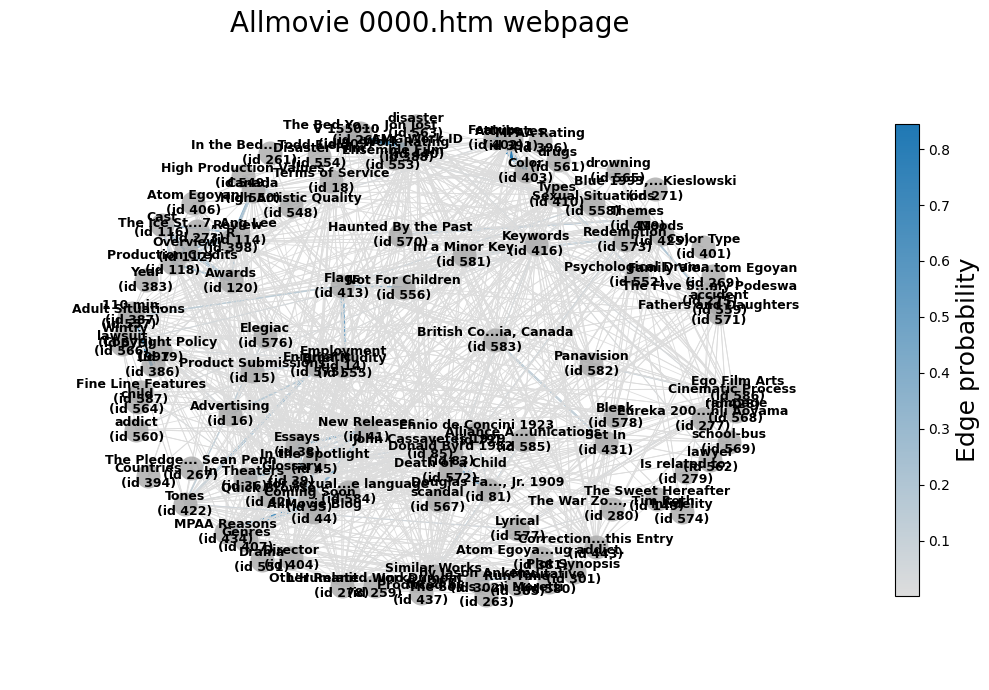

In [11]:
mask = np.where(probs>=0.000001)
t,s,x,p = txts[mask],sorted_label_index[mask],xpaths[mask],probs[mask]

# Displaying the graph before all the pruning steps
_=draw_graph_from_arrays(
    txt_edge_pairs=t,
    id_edge_pairs=s,
    xpath_edge_pairs=x,
    probs=p,
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(10, 7),
    title="Allmovie 0000.htm webpage",
    draw_edge_labels=False,
    node_txt_colour="black",
)

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least two edges per node are saved

In [12]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = np.array(mask, dtype=bool) 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
[print(edge) for edge in txts[~mask]]
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

11556  ->  270
['In Theaters' 'Quick Browse']
['In Theaters' 'In the Spotlight']
['Coming Soon' 'Quick Browse']
['In the Spotlight' 'John Cassavetes 1929']
['Glossary' 'Quick Browse']
['New Releases' 'AllMovie Blog']
['New Releases' 'John Cassavetes 1929']
['AllMovie Blog' 'In Theaters']
['In Theaters' 'AllMovie Blog']
['Advertising' 'New Releases']
['Glossary' 'AllMovie Blog']
['AllMovie Blog' 'Coming Soon']
['Coming Soon' 'AllMovie Blog']
['Advertising' 'In the Spotlight']
['In the Spotlight' 'Donald Byrd 1932']
['In the Spotlight' 'Ennio de Concini 1923']
['Employment' 'New Releases']
['Employment' 'In the Spotlight']
['Donald Byrd 1932' 'New Releases']
['New Releases' 'Donald Byrd 1932']
['Copyright Policy' 'New Releases']
['Product Submissions' 'New Releases']
['Advertising' 'Glossary']
['John Cassavetes 1929' 'Glossary']
['Glossary' 'John Cassavetes 1929']
['Copyright Policy' 'In the Spotlight']
['Product Submissions' 'In the Spotlight']
['Ennio de Concini 1923' 'New Releases']
[

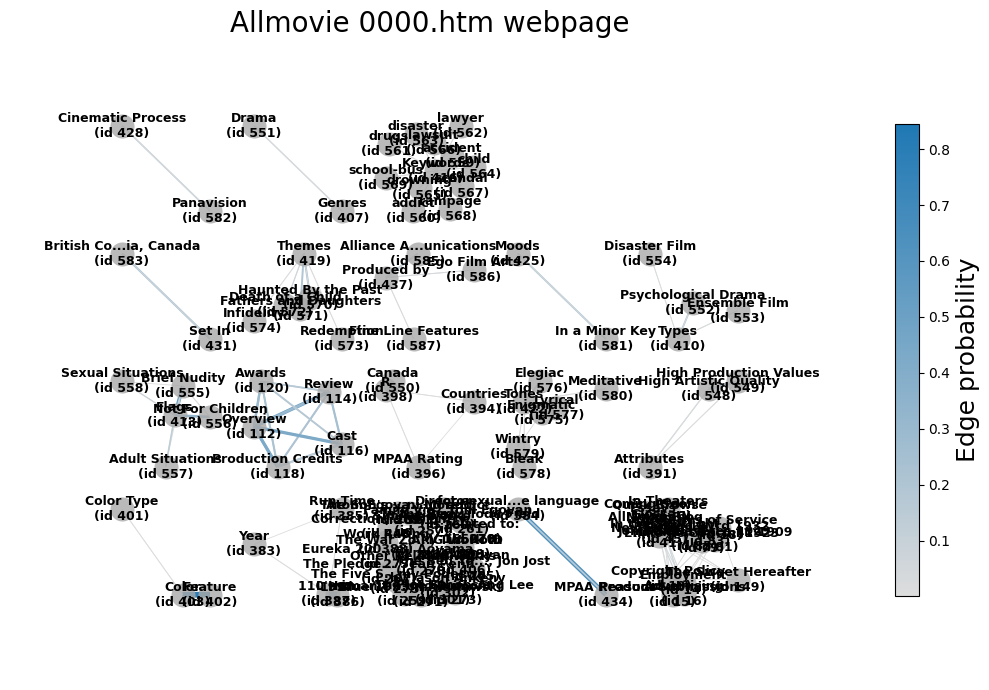

In [13]:
_=draw_graph_from_arrays(
    txt_edge_pairs=txts,
    id_edge_pairs=sorted_label_index,
    xpath_edge_pairs=xpaths,
    probs=probs,
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(10, 7),
    title="Allmovie 0000.htm webpage",
    draw_edge_labels=False,
    node_txt_colour="black",
)

### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [14]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [15]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [16]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [17]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [18]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['Essays' 'Quick Browse']
 ['Quick Browse' 'In Theaters']
 ['Cast' 'Production Credits']
 ['Cast' 'Awards']
 ['Sexual Situations' 'Flags']
 ['Employment' 'Copyright Policy']
 ['John Cassavetes 1929' 'Copyright Policy']
 ['Donald Byrd 1932' 'Terms of Service']
 ['John Cassavetes 1929' 'Terms of Service']
 ['Year' '110 min.']
 ["Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand Jury Prize at the 1997 Cannes Film Festival and scoring a pair of Academy Award nominations, including Best Director. Restructured to fit Egoyan's signature mosaic narrative style, the story concerns the cultural aftershocks which tear apart a small British Columbia town in the wake of a school-bus accident which leaves a number of local children dead. Ian Holm stars as Mitchell Stephens, a big-city lawyer who arrives in the interest of uniting the survivors to init

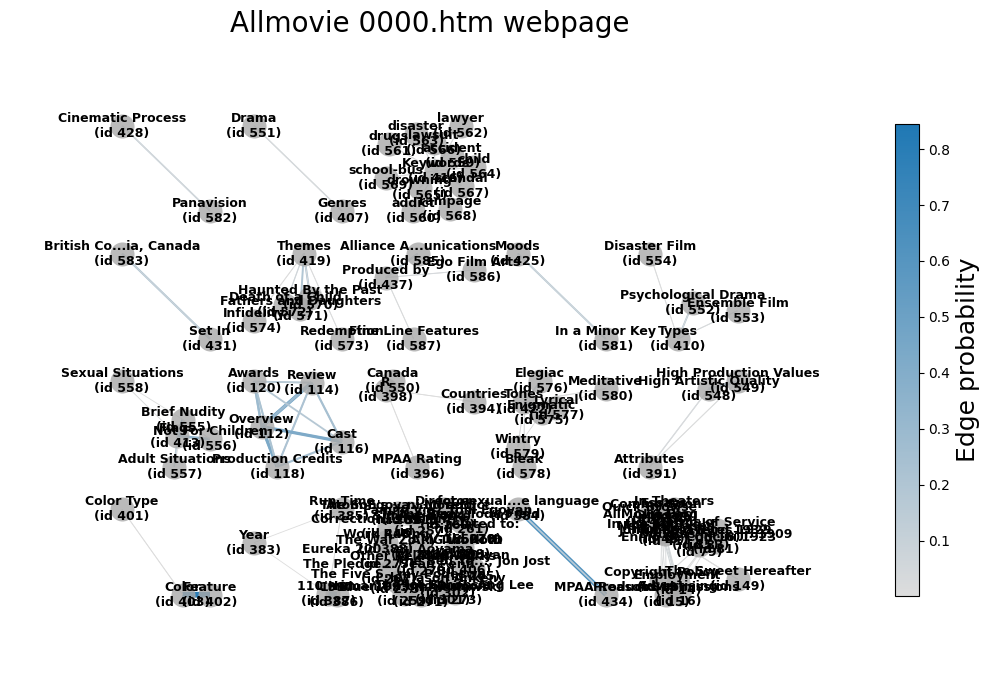

In [19]:
_=draw_graph_from_arrays(
    txt_edge_pairs=txts,
    id_edge_pairs=sorted_label_index,
    xpath_edge_pairs=xpaths,
    probs=probs,
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(10, 7),
    title="Allmovie 0000.htm webpage",
    draw_edge_labels=False,
    node_txt_colour="black",
)

### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [37]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist(), batch_size=32)
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

0 Employment
0 Product Submissions
0 Advertising
0 Terms of Service
0 Copyright Policy
0 Coming Soon
0 In Theaters
0 Essays
0 Glossary
0 New Releases
0 Quick Browse
0 AllMovie Blog
0 In the Spotlight
0 Ennio de Concini 1923
0 Douglas Fairbanks, Jr. 1909
0 Donald Byrd 1932
0 John Cassavetes 1929
0 Overview
0 Review
0 Cast
1 Production Credits
0 Awards
0 The Sweet Hereafter
0 Similar Works
0 L'Humanit 1999, Bruno Dumont
0 In the Bedroom 2001, Todd Field
1 The Son's Room 2001, Nanni Moretti
1 The Bed You Sleep In 1993, Jon Jost
0 The Pledge 2001, Sean Penn
0 Family Viewing 1987, Atom Egoyan
0 Blue 1993, Krzysztof Kieslowski
0 The Ice Storm 1997, Ang Lee
1 The Five Senses 1999, Jeremy Podeswa
0 Eureka 2000, Shinji Aoyama
0 Other Related Works
0 Is related to:
0 The War Zone 1999, Tim Roth
1 Plot Synopsis
0 by Jason Ankeny
1 Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand 

In [38]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences, node_sentences_xpaths = node_unique_txts[isSentence], node_unique_xpaths[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext, cost_needsContext, _ = classify_needsContext_openAI(node_sentences, dry_run_confirm=False, batch_size=1, return_raw_response_and_cost=True)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
else:
    sentenceNeedsContext, cost_needsContext = np.zeros(node_sentences.shape, dtype=bool), 0
padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])




Batch 0 ~input tokens=103, ~output tokens=2, est. cost=$0.0004 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 99  {input_tokens= 97  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 4.2000000000000004e-05  This batch cost: $ 4.2000000000000004e-05
output so far:  [NEWBATCH]0
results so far:  [0]

Batch 1 ~input tokens=113, ~output tokens=2, est. cost=$0.0004 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 109  {input_tokens= 107  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 8.800000000000001e-05  This batch cost: $ 4.600000000000001e-05
output so far:  [NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0]

Batch 2 ~input tokens=113, ~output tokens=2, est. cost=$0.0004 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 109  {input_tokens= 107  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.000134  This batch cost: $ 4.600000000000001e-05
output so far:  [NEWBATCH]0[NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0, 0]

Batch 3 ~input tokens=113, ~output tokens=2, est. cost=$0.

In [39]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        #print("XX ", word, " XX")
    else:
        pass#print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [40]:
padded_sentenceNeedsContext = np.array(padded_sentenceNeedsContext, dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges, needsContext_xpaths = txts[mask], xpaths[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:
Haunted By the Past


In [41]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

0
[['Haunted By the Past' 'Themes']]


In [42]:
print(needsContext_text_edges)

[['Haunted By the Past' 'Themes']]


In [43]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost_pairwiseEdges = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost_pairwiseEdges += cost
    print("Running cost: $", runningCost_pairwiseEdges)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges, needsContext_xpaths = needsContext_text_edges[mask], needsContext_xpaths[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)

Removed  []


In [ ]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost_add_context = add_context(needsContext_text_edges, dry_run_confirm=False, return_raw_response_and_cost=True)
facts_noContext, cost_summarise = summairse(node_sentences[~sentenceNeedsContext], dry_run_confirm=False, return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost_add_context+cost_summarise)

1 8

Batch 1 (pairs 0..0): ~input tokens=126, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)


Total_tokens= 144  {input_tokens= 140  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 1.56e-05  This batch cost: $ 1.56e-05
results so far:  ['NO FACTS']

Batch 0: ~input tokens=122, ~output tokens=2, est. cost=$0.0001 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
gpt-4.1-nano
Total_tokens= 134  {input_tokens= 130  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 1.4599999999999999e-05  This batch cost: $ 1.4599999999999999e-05
results so far:  ['NO FACTS']

Batch 1: ~input tokens=132, ~output tokens=2, est. cost=$0.0001 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
gpt-4.1-nano
Total_tokens= 144  {input_tokens= 140  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 3.02e-05  This batch cost: $ 1.56e-05
results so far:  ['NO FACTS', 'NO FACTS']

Batch 2: ~input tokens=132, ~output tokens=2, est. cost=$0.0001 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
gpt-4.1-nano
Total_tokens= 144  {input_tokens= 140  reasoning_tokens= 0  output_tokens= 4 }
Runni

In [ ]:
for fact, xp in zip(facts_context, needsContext_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append(xp)

for fact, xp in zip(facts_noContext, node_sentences_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append([xp])

for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

Atom Egoyan directed the film adaptation of the Russell Banks novel The Sweet Hereafter.  
The Sweet Hereafter won a Special Grand Jury Prize at the 1997 Cannes Film Festival.  
The Sweet Hereafter received two Academy Award nominations, including Best Director.  
The Sweet Hereafter is set in a small British Columbia town affected by a school-bus accident that killed several local children.  
Ian Holm stars as Mitchell Stephens, a lawyer who arrives to unite survivors for a lawsuit in The Sweet Hereafter.  
Mitchell Stephens' actions in The Sweet Hereafter cause further division in the community.  
The Sweet Hereafter explores themes of family grief and emotional devastation.  
Mitchell Stephens in The Sweet Hereafter is motivated partly by remorse over his HIV-positive drug addict daughter.
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/div/table/tbody/tr[2]/td/p')]



In [ ]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)


	 Production Credits
NO FACTS
	 The Son's Room 2001, Nanni Moretti
NO FACTS
	 The Bed You Sleep In 1993, Jon Jost
NO FACTS
	 The Five Senses 1999, Jeremy Podeswa
NO FACTS
	 Plot Synopsis
NO FACTS
	 Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand Jury Prize at the 1997 Cannes Film Festival and scoring a pair of Academy Award nominations, including Best Director. Restructured to fit Egoyan's signature mosaic narrative style, the story concerns the cultural aftershocks which tear apart a small British Columbia town in the wake of a school-bus accident which leaves a number of local children dead. Ian Holm stars as Mitchell Stephens, a big-city lawyer who arrives in the interest of uniting the survivors to initiate a lawsuit his maneuvering only drives the community further apart, reopening old wounds and jeopardizing any hopes of emotional recovery. Like so many of Egoy

In [ ]:
# total cost
print(cost_add_context + cost_summarise + runningCost_pairwiseEdges + cost_needsContext)

### 7b. Cluster the non sentence nodes together ###
This uses Leiden clustering. Louvain also available

This makes a new, simple classification of sentence as "more than x words" (instead of that above using FLAN-T5)

In [20]:
#To still do: Link all the small text nodes
#Output XPaths so we know where the nodes came from
NUMWORDSPERSENTENCE = np.inf
manyWordsMask = np.zeros(len(sorted_label_index), dtype=bool)
for idx, (first, second) in enumerate(txts):
    if len(first.split()) > NUMWORDSPERSENTENCE or len(second.split()) > NUMWORDSPERSENTENCE:
        manyWordsMask[idx] = True

no_sent_label_index, no_sent_txts, no_sent_probs, no_sent_xpaths = sorted_label_index[~manyWordsMask], txts[~manyWordsMask], probs[~manyWordsMask], xpaths[~manyWordsMask]

node_meta = defaultdict(lambda: {"texts": set(), "xpaths": set()})
for (u, v), (t1, t2), (x1, x2) in zip(no_sent_label_index, no_sent_txts, no_sent_xpaths):
    node_meta[u]["texts"].add(t1); node_meta[u]["xpaths"].add(x1)
    node_meta[v]["texts"].add(t2); node_meta[v]["xpaths"].add(x2)

#clusters = leiden_clustering(no_sent_label_index, no_sent_probs)
clusters = iterative_leiden(no_sent_label_index, no_sent_probs, node_meta, max_words=30)
clusters = [cluster[::-1] for cluster in clusters] #Reorder IF LEIDEN as the output above seems to put titles at the bottom

In [21]:
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i} -> nodes: {cluster}")
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        #print(f"    - Node {n}: text=[{t}]")
        print("\"",t,"\"", sep="", end=",\n")

def count_cluster_words(cluster):
    count = 0
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        count += len(t.split())
    return count

  Cluster 0 -> nodes: [388, 263, 265, 267, 269, 261, 275, 273, 271, 259, 277, 443, 257]
"Work Rating",
"The Son's Room 2001, Nanni Moretti",
"The Bed You Sleep In 1993, Jon Jost",
"The Pledge 2001, Sean Penn",
"Family Viewing 1987, Atom Egoyan",
"In the Bedroom 2001, Todd Field",
"The Five Senses 1999, Jeremy Podeswa",
"The Ice Storm 1997, Ang Lee",
"Blue 1993, Krzysztof Kieslowski",
"L'Humanit 1999, Bruno Dumont",
"Eureka 2000, Shinji Aoyama",
"Corrections to this Entry",
"Similar Works",
  Cluster 1 -> nodes: [279, 278, 280]
"Is related to:",
"Other Related Works",
"The War Zone 1999, Tim Roth",
  Cluster 2 -> nodes: [381, 302, 301]
"Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand Jury Prize at the 1997 Cannes Film Festival and scoring a pair of Academy Award nominations, including Best Director. Restructured to fit Egoyan's signature mosaic narrative style, the sto

Tried extra clustering within clusters but it didn't add much. Would of had to be fine tuned per website to give any useful information. semantic grouping would have been much better

In [22]:
mini_graphs, mini_probs = mini_graphs_from_clusters(no_sent_label_index, no_sent_probs, clusters)
# mini_clusters = []
# for g, p in zip(mini_graphs, mini_probs):
#     print(g)
#     mini_cluster = louvain_clustering(g, p, 1.2)
#     print(mini_cluster)
#     print()
#     mini_clusters.append(mini_cluster)

In [23]:
# for clusters in mini_clusters:
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i} -> nodes: {cluster}")
#         for n in cluster:
#             t = ", ".join(node_meta[n]["texts"])
#             #print(f"    - Node {n}: text=[{t}]")
#             print("\"",t,"\"", sep="", end=",\n")

Tried rudimentury grouping within clusters using an llm, but it didn't work too well enough to justify the cost

In [ ]:
clusters_text = [[". ".join(node_meta[n]["texts"]) for n in cluster] for cluster in clusters]
clusters_xpaths = [[". ".join(node_meta[n]["xpaths"]) for n in cluster] for cluster in clusters]
_=[print(c) for c in clusters_text]

['Work Rating', "The Son's Room 2001, Nanni Moretti", 'The Bed You Sleep In 1993, Jon Jost', 'The Pledge 2001, Sean Penn', 'Family Viewing 1987, Atom Egoyan', 'In the Bedroom 2001, Todd Field', 'The Five Senses 1999, Jeremy Podeswa', 'The Ice Storm 1997, Ang Lee', 'Blue 1993, Krzysztof Kieslowski', "L'Humanit 1999, Bruno Dumont", 'Eureka 2000, Shinji Aoyama', 'Corrections to this Entry', 'Similar Works']
['Is related to:', 'Other Related Works', 'The War Zone 1999, Tim Roth']
["Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand Jury Prize at the 1997 Cannes Film Festival and scoring a pair of Academy Award nominations, including Best Director. Restructured to fit Egoyan's signature mosaic narrative style, the story concerns the cultural aftershocks which tear apart a small British Columbia town in the wake of a school-bus accident which leaves a number of local children 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
clusters_less_words = [c for c in clusters_text if count_cluster_words(c)>30]
clusters_xpaths = [x for x, c in zip(clusters_xpaths, clusters_text) if count_cluster_words(c)>30]
cluster_summaries = summarise_cluster(clusters_text, batch_size=8)
print(cluster_summaries)

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 0 has a total capacity of 15.58 GiB of which 20.56 MiB is free. Process 4172509 has 3.96 GiB memory in use. Including non-PyTorch memory, this process has 11.51 GiB memory in use. Of the allocated memory 10.59 GiB is allocated by PyTorch, and 657.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for model_outputs in cluster_summaries:
    model_cluster = model_outputs.split("\n")
    for m in model_cluster:
        entries = m.strip().split(" | ")
        print(entries)

["1. John Gray - The SevenUps 1973. 2. Phil D'Antoni - The Dead Pool 1988. 3. Buddy Van Horn - Coogan's Bluff 1968. 4. Don Siegel - The Enforcer 1976. 5. James Fargo - The Gauntlet 1977. 6. Clint Eastwood - Sharky's Machine 1981. 7. Burt Reynolds - The Hunter 1980. 8. Buzz Kulik - To Live and Die in L.A. 1985. 9. William Friedkin - Dirty Harry 1971."]
['1. Peter Yates is a director. 2.']
['1. Is spoofed in: Dollars 1971, Richard Brooks. 2. Is related to: The Making of Bullitt. 3. Other Related Works.']
["1. Robert L. Pike's crime novel Mute Witness makes the transition to the big screen in this film from director Peter Yates. 2. In one of his most famous roles, Steve McQueen stars as toughguy police detective Frank Bullitt. 3. The story begins with Bullitt assigned to a seemingly routine detail, protecting mafia informant Johnny Ross Pat Renella, who is scheduled to testify against his Mob cronies before a Senate subcommittee in San Francisco. 4. When a pair of hitmen ambush their secr

### 8. Final fact output ###
Outputing all the facts and groupings found, with xpaths to lead back to the source

In [ ]:
new_edges = []
new_txts = []
new_xpaths = []
new_probs = []
for g, p in zip(mini_graphs, mini_probs):
    for edge, prob in zip(g, p):
        u, v = edge
        if [int(u), int(v)] not in sorted_label_index.tolist() and [int(v), int(u)] not in sorted_label_index.tolist():
            print(edge, "not found", end=", ")
            continue
        u_txt, u_xpath = "|".join(node_meta[u]["texts"]), "|".join(node_meta[u]["xpaths"])
        v_txt, v_xpath = "|".join(node_meta[v]["texts"]), "|".join(node_meta[v]["xpaths"])
        new_edges.append(edge)
        new_txts.append([u_txt, v_txt])
        new_xpaths.append([u_xpath, v_xpath])
        new_probs.append(prob)
print()
new_edges, new_txts, new_xpaths, new_probs = np.array(new_edges), np.array(new_txts), np.array(new_xpaths), np.array(new_probs)
print(new_edges)
print(new_txts)
print(new_xpaths)
print(new_probs)


[[257 443]
 [257 277]
 [257 259]
 [257 271]
 [257 273]
 [257 275]
 [257 261]
 [257 269]
 [257 267]
 [257 265]
 [257 263]
 [257 388]
 [280 278]
 [278 279]
 [301 302]
 [301 381]
 [381 302]
 [404 406]
 [ 35  39]
 [ 35  41]
 [ 35  45]
 [ 35  42]
 [ 35  38]
 [ 35  36]
 [ 36  45]
 [ 36  38]
 [ 36  39]
 [ 36  41]
 [ 38  42]
 [ 38  44]
 [ 38  41]
 [ 38  45]
 [ 38  39]
 [ 39  41]
 [ 39  45]
 [ 39  42]
 [ 39  44]
 [ 39  16]
 [ 41  45]
 [ 41  42]
 [ 41  44]
 [ 41  16]
 [ 41  14]
 [ 41  19]
 [ 41  15]
 [ 41 149]
 [ 42  45]
 [ 42  44]
 [ 44  45]
 [ 45  16]
 [ 45  14]
 [ 45  19]
 [ 45  15]
 [ 45 149]
 [ 14  15]
 [ 14  16]
 [ 14  19]
 [ 14  18]
 [ 15  16]
 [ 15  19]
 [ 15  18]
 [ 16  19]
 [ 16  18]
 [ 18  19]
 [416 559]
 [416 565]
 [416 566]
 [416 567]
 [416 564]
 [416 563]
 [416 568]
 [416 560]
 [416 562]
 [416 569]
 [416 561]
 [576 422]
 [576 575]
 [577 422]
 [578 422]
 [579 422]
 [579 575]
 [580 422]
 [580 575]
 [422 575]
 [419 570]
 [419 571]
 [419 572]
 [419 573]
 [419 574]
 [555 413]
 [555 556

In [ ]:
for i, cluster in enumerate(clusters):
    textInCluster, xpathInCluster = [], []
    for n in cluster:
        t, xp = ", ".join(node_meta[n]["texts"]), ", ".join(node_meta[n]["xpaths"])
        textInCluster.append(t)
        xpathInCluster.append(xp)
    LISTOFFACTS.append(textInCluster)
    LISTOFXPATHS.append(xpathInCluster)
        

In [ ]:
for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

['Work Rating', "The Son's Room 2001, Nanni Moretti", 'The Bed You Sleep In 1993, Jon Jost', 'The Pledge 2001, Sean Penn', 'Family Viewing 1987, Atom Egoyan', 'In the Bedroom 2001, Todd Field', 'The Five Senses 1999, Jeremy Podeswa', 'The Ice Storm 1997, Ang Lee', 'Blue 1993, Krzysztof Kieslowski', "L'Humanit 1999, Bruno Dumont", 'Eureka 2000, Shinji Aoyama', 'Corrections to this Entry', 'Similar Works']
['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[3]/td/table/tbody/tr[1]/td', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[4]/td[2]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[5]/td[2]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[6]/td[2]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tb

### Final edge output ###
Here are the results after all the filtering


In [ ]:
# Display the graph
textmask = np.array([True]*len(new_txts))
#textmask = filterTextMask(new_txts, "Sarah Rainsford", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(new_edges[textmask][:numToShow], new_xpaths[textmask][:numToShow], new_txts[textmask][:numToShow], new_probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=new_txts[textmask][:numToShow],
    id_edge_pairs=new_edges[textmask][:numToShow],
    xpath_edge_pairs=new_xpaths[textmask][:numToShow],
    probs=new_probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(10, 8),
    title="NFL Webpage Clusters",
    font_size=10,
    node_txt_colour="black",
    node_size=500
)

NameError: name 'new_txts' is not defined

['AMG Work ID' 'V 7534']
['V 7534' 'AMG Work ID']
['Color' 'Feature']
['Feature' 'Color']
['105 min.' '1968']
['1968' '105 min.']
['USA' 'PG']
['PG' 'USA']
['Glossary' 'Coming Soon']
['Coming Soon' 'Glossary']
['Sylvia 1956' 'Morten Grunwald 1934']
['Morten Grunwald 1934' 'Sylvia 1956']
['Sylvia 1956' 'Dan Hicks 1941']
['Dan Hicks 1941' 'Sylvia 1956']
['AllMovie Blog' 'Essays']
['Essays' 'AllMovie Blog']
['Questionable for Children' 'Flags']
['Flags' 'Questionable for Children']
['New Releases' 'Essays']
['Essays' 'New Releases']
['San Francisco, CA' 'Set In']
['Set In' 'San Francisco, CA']
['Quick Browse' 'Essays']
['Morten Grunwald 1934' 'Berton Churchill 1876']
['Berton Churchill 1876' 'Morten Grunwald 1934']
['In the Spotlight' 'In Theaters']
['Mute Witness' 'From book']
['From book' 'Mute Witness']
['Dan Hicks 1941' 'Berton Churchill 1876']
['Berton Churchill 1876' 'Dan Hicks 1941']
['In the Spotlight' 'Quick Browse']
['Quick Browse' 'In the Spotlight']
['New Releases' 'Coming Soo

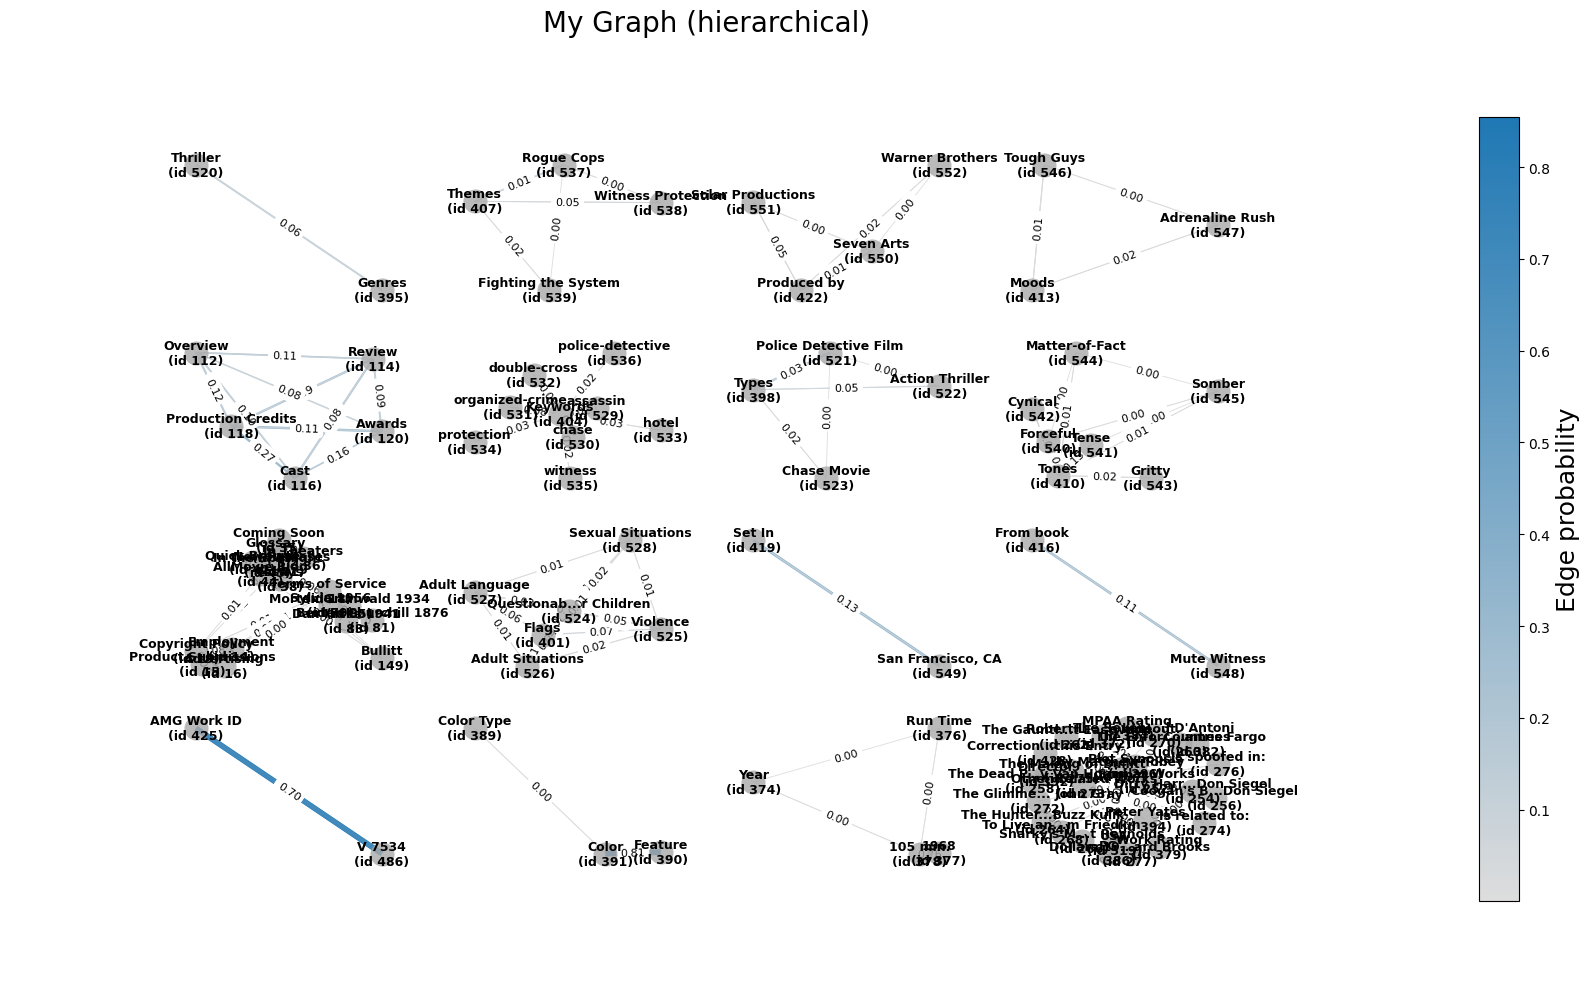

{'G': <networkx.classes.digraph.DiGraph at 0x70eba86ebec0>,
 'pos': {425: (np.float64(0.0), np.float64(1.0)),
  486: (np.float64(1.0), np.float64(0.0)),
  389: (np.float64(1.5), np.float64(1.0)),
  390: (np.float64(2.5), np.float64(0.011382001571414706)),
  391: (np.float64(2.2035868549519853), np.float64(0.0)),
  376: (np.float64(4.0), np.float64(1.0)),
  377: (np.float64(3.9967430160295683), np.float64(0.0018413611149999513)),
  378: (np.float64(3.894783700601606), np.float64(0.0)),
  374: (np.float64(3.0), np.float64(0.5713678489259582)),
  384: (np.float64(5.010174879002964), np.float64(1.0)),
  256: (np.float64(5.482934458399673), np.float64(0.44046285757028864)),
  386: (np.float64(4.910012135260303), np.float64(0.007380420844673154)),
  258: (np.float64(4.5), np.float64(0.5761555802234891)),
  260: (np.float64(5.29580395978513), np.float64(0.8729692921864982)),
  262: (np.float64(4.684299439233154), np.float64(0.9315252705792111)),
  519: (np.float64(4.942479739687517), np.float

In [ ]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)